In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm

   user_id  click group            timestamp
0        1      1   exp  2024-01-01 00:00:00
1        2      0   exp  2024-01-01 00:01:00
2        3      1   exp  2024-01-01 00:02:00
3        4      0   exp  2024-01-01 00:03:00
4        5      1   exp  2024-01-01 00:04:00
            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000
group
con    1989
exp    6116
Name: click, dtype: int64


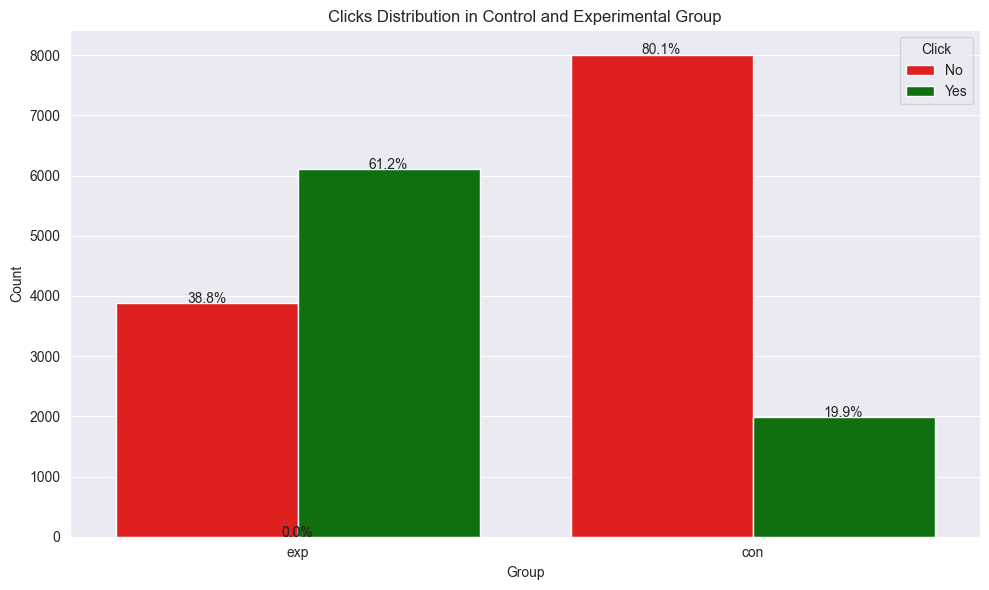

In [60]:
df_ab_test = pd.read_csv("../data/ab_test_click_data.csv")
print(df_ab_test.head())
print(df_ab_test.describe())
print(df_ab_test.groupby("group")["click"].sum())

palette = {0: "red", 1: "green"}
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="group", hue="click", data=df_ab_test, palette=palette)
plt.legend(title="Click", labels=["No", "Yes"])
plt.title("Clicks Distribution in Control and Experimental Group")
plt.xlabel("Group")
plt.ylabel("Count")

group_counts = df_ab_test.groupby(["group"]).size()
group_click_counts = df_ab_test.groupby(["group", "click"]).size().reset_index(name="count")

for i in ax.patches:
    height = i.get_height()

    group = 'exp' if i.get_x() == 0.0 else 'con'
    click = 'yes' if i.get_x() == 0.0 else 'no'
    total = group_counts.loc[group]
    percentage = 100 * height / total
    # Show text on graph displaying percentages
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.5, f"{percentage:.1f}%", ha="center")

plt.tight_layout()
plt.show()

In [61]:
alpha = 0.05
print("Alpha: Significance Level: ", alpha)

delta = 0.1
print("Delta: Minimum Detectable Effect: ", delta)

Alpha: Significance Level:  0.05
Delta: Minimum Detectable Effect:  0.1


In [62]:
# Total number of clicks in each group
X_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]
X_con = df_ab_test.groupby("group")["click"].sum().loc["con"]

# Number of users in each group
N_exp = df_ab_test[df_ab_test["group"] == "exp"].shape[0]
N_con = df_ab_test[df_ab_test["group"] == "con"].shape[0]

# Outputting the total number of clicks in each group
print("Total Clicks in Experimental Group: ", X_exp)
print("Total Clicks in Control Group: ", X_con)

# Outputting the number of users in each group
print("Total Users in Experimental Group: ", N_exp)
print("Total Users in Control Group: ", N_con)


Total Clicks in Experimental Group:  6116
Total Clicks in Control Group:  1989
Total Users in Experimental Group:  10000
Total Users in Control Group:  10000


In [63]:
p_exp_hat = X_exp / N_exp
p_con_hat = X_con / N_con

# Outputting the click probability in each group
print("Click Probability in Experimental Group: ", p_exp_hat)
print("Click Probability in Control Group: ", p_con_hat)

p_pooled_hat = (X_exp + X_con) / (N_exp + N_con)

# Outputting the pooled click probability
print("Pooled Click Probability: ", p_pooled_hat)

Click Probability in Experimental Group:  0.6116
Click Probability in Control Group:  0.1989
Pooled Click Probability:  0.40525


# Calculating pooled variance   

In [64]:
pooled_variance = p_pooled_hat * (1 - p_pooled_hat) * (1 / N_exp + 1 / N_con)
print("P^_pooled: ", p_pooled_hat)
print("Pooled Variances: ", pooled_variance)

P^_pooled:  0.40525
Pooled Variances:  4.82044875e-05


## Calculating the standard error

In [65]:
SE = np.sqrt(pooled_variance)

#Outputting standard error
print("Standard Error: ", SE)

# Computing the test statistic of the two-sample z-test
test_stat = (p_con_hat - p_exp_hat) / SE
# Outputting the test statistic
print("Test Statistic for the two sample Z test is: ", test_stat)

# Calculating the critical Z value
z_critical = norm.ppf(1 - alpha / 2)
print("Critical Z Value: ", z_critical)

Standard Error:  0.006942945160376826
Test Statistic for the two sample Z test is:  -59.44163326469381
Critical Z Value:  1.959963984540054


## Calculating p_values of the Z-test

    -  A low p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.
    -  A high p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.
    -  p-values very close to the cutoff (0.05) are considered to be marginal (could go either way). Always report the p-value so your readers can draw their own conclusions.

In [66]:
p_value = 2 * norm.sf(np.abs(test_stat))


# Checking statistical significance
def check_statistical_significance(p_value, alpha):
    print("P-Value of the 2 sample Z test is: ", round(p_value, 3))
    if p_value <= alpha:
        print(
            "Reject the null hypothesis: There is a statistically significant difference between the two proportions, and it is not by chance")
    else:
        print(
            "Fail to reject the null hypothesis: There is no statistically significant difference between the two proportions, and it is by chance")


check_statistical_significance(p_value, alpha)

P-Value of the 2 sample Z test is:  0.0
Reject the null hypothesis: There is a statistically significant difference between the two proportions, and it is not by chance


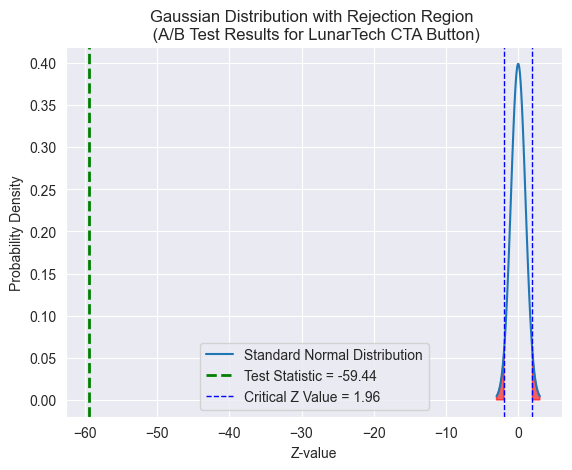

In [67]:
mu = 0
sigma = 1
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
y = norm.pdf(x, mu, sigma)

# Plotting the standard normal distribution/Gaussian distribution
plt.plot(x, y, label="Standard Normal Distribution")
# Shade the rejection region
plt.fill_between(x, y, where=(x > z_critical) | (x < -z_critical), color="red", alpha=0.6)
# Adding test statistic
plt.axvline(test_stat, color="green", linestyle="--", linewidth=2, label=f"Test Statistic = {test_stat:.2f}")
# Adding the critical z value
plt.axvline(z_critical, color="blue", linestyle="--", linewidth=1, label=f"Critical Z Value = {z_critical:.2f}")
plt.axvline(-z_critical, color="blue", linestyle="--", linewidth=1)

# Adding labels and title
plt.title("Gaussian Distribution with Rejection Region \n (A/B Test Results for LunarTech CTA Button)")
plt.xlabel("Z-value")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

## Calculate the confidence region

In [68]:
# calculating the confidence interval
CI = [
    round((p_exp_hat - p_con_hat) - SE * z_critical, 3),  # Lower bound
    round((p_exp_hat - p_con_hat) + SE * z_critical, 3)  # Upper bound
]

# Outputting the confidence interval
print("Confidence Interval of the 2 sample Z test is: ", CI)

Confidence Interval of the 2 sample Z test is:  [np.float64(0.399), np.float64(0.426)]


## Testing for Practical Significance

In [72]:
def check_practical_significance(CI_95, delta):
    # Extract lower bound of confidence interval
    lower_bound_CI = CI_95[0]
    if delta <= lower_bound_CI:
        print(
            "Practically Significant: The difference is meaningful and substantial. \nImplement the new design: \nSince the lower bound of the confidence interval is greater than the practical significance level\n"
            f"{lower_bound_CI} > {delta}")
    else:
        print(
            "Not Practically Significant: The difference is not meaningful or substantial. \nDo not implement the new design: \nSince the lower bound of the confidence interval is less than the practical significance level\n"
            f"{lower_bound_CI} < {delta}")


CI_95 = (CI[0], CI[1])
check_practical_significance(CI_95, delta)

Practically Significant: The difference is meaningful and substantial. 
Implement the new design: 
Since the lower bound of the confidence interval is greater than the practical significance level
0.399 > 0.1
